In [113]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
    return 3*x**3 - 5*x + 2

In [ ]:
f(4)

In [ ]:
xs = np.arange(-5, 5, 0.1)
ys = f(xs)
plt.plot(xs, ys)
plt.grid()

In [ ]:
h = 0.01
x = 0
(f(xs + h) - f(xs)) / h

In [ ]:
plt.plot(xs, (f(xs + h) - f(xs)) / h)
plt.grid()

In [ ]:
h = 0.0000000001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a += h
d2 = a*b + c
print("deriv a:", (d2 - d1) / h)
a = 2.0
b = -3.0
c = 10.0
c += h
d3 = a*b + c
print ("deriv c:", (d3 - d1) / h)
a = 2.0
b = -3.0
c = 10.0
b += h
d4 = a*b + c
print ("deriv b:", (d4 - d1) / h)

In [ ]:
class Value:
    def __init__(self, data):
        self.data = data
    def __repr__(self):
        return f"Value({self.data})"
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
e = a * b
f = e + c
print(f)

In [9]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._children = _children
        self._op = _op
        self.label = label
        self.grad = 0.0
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        return out
    def __div__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data / other.data, (self, other), '/')
        return out
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), '-')
        return out
    def __radd__(self, other):
        return self + other
    def __rmul__(self, other):
        return self * other
    def __rdiv__(self, other):
        return self / other
    def __rsub__(self, other):
        return self - other
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        return out
    def gradient(self, other):
        self_data = self.data
        other.data += 0.0000001
        #print(other.data, self.data)
        def build(v):
            if v == other:
                return other.data
            if v._op == '':
                return v.data
            elif v._op == '+':
                #print (v, v._op, v._children)
                return build(v._children[0]) + build(v._children[1])
            elif v._op == '*':
                #print (v, v._op, v._children)
                return build(v._children[0]) * build(v._children[1])
            elif v._op == 'tanh':
                #print (v, v._op, v._children)
                x = build(v._children[0])
                t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
                return t
            elif v._op == 'exp':
                #print (v, v._op, v._children)
                x = build(v._children[0])
                return math.exp(x)
            elif v._op == '/':
                #print (v, v._op, v._children)
                return build(v._children[0]) / build(v._children[1])
            elif v._op.startswith('**'):
                #print (v, v._op, v._children)
                power = float(v._op[2:])
                return build(v._children[0]) ** power
        other_grad_pos = build(self)
        #print(other_grad_pos)
        other.grad = (other_grad_pos - self_data)/0.0000001
        other.data -= 0.0000001
    def __repr__(self):
        return f"Value(data={self.data}), label={self.label}, children={len(self._children)}, op={self._op})"

In [166]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a * b; d.label='d'
f = d + c; f.label='f'
d1 = f + c; d1.label='d1'
e = d1 * d; e.label='e'
L = f * e; L.label='L'
print(f)

Value(data=4.0), label=f, children=2, op=+)


f.grad :  -108.00000097788143


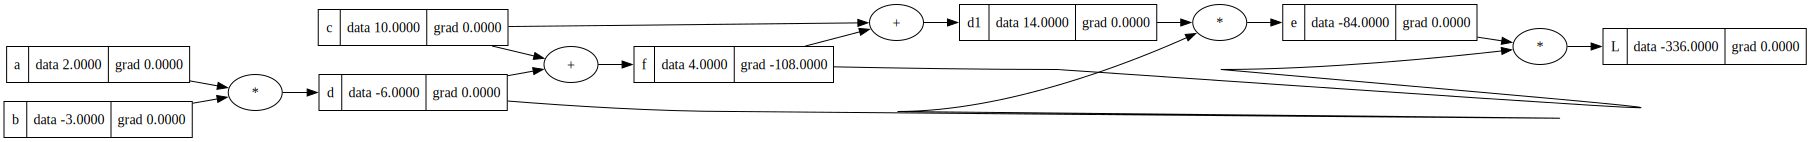

In [167]:
L.gradient(f)
print("f.grad : ", f.grad)
draw_dot(L)

In [143]:
import subprocess

In [10]:
import graphviz

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = graphviz.Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

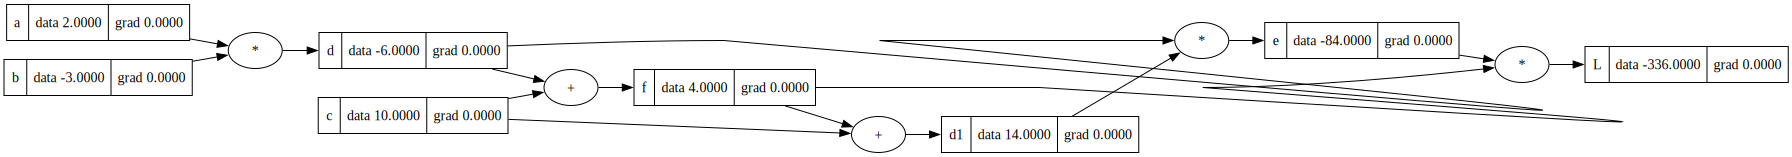

In [110]:
draw_dot(L)

In [49]:
print(e)

Value(data=-6.0)


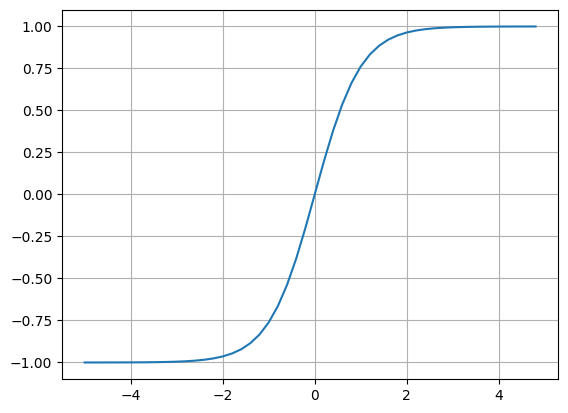

In [115]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [193]:
x1 = Value(2.0, label='x1')
w1 = Value(-3.0, label='w1')
x2 = Value(0.0, label='x2')
w2 = Value(1.0, label='w2')
b = Value(6.8814, label='b')
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'



In [195]:
for p in [x1, w1, x2, w2, b, o]:
    #print(p)
    o.gradient(p)
    print(f"grad of {p.label} = {p.grad}")

grad of x1 = -1.499944288774202
grad of w1 = 0.9999625072421026
grad of x2 = 0.49998129303396865
grad of w2 = 4.440892098500626e-09
grad of b = 0.49998129303396865
grad of o = 0.9999999994736442


In [194]:
o.gradient(o)
print(o.grad)
o.gradient(n)
print(n.grad)
o.gradient(x1w1)
print(x1w1.grad)

0.9999999994736442
0.49998128748285353
0.4999812897032996


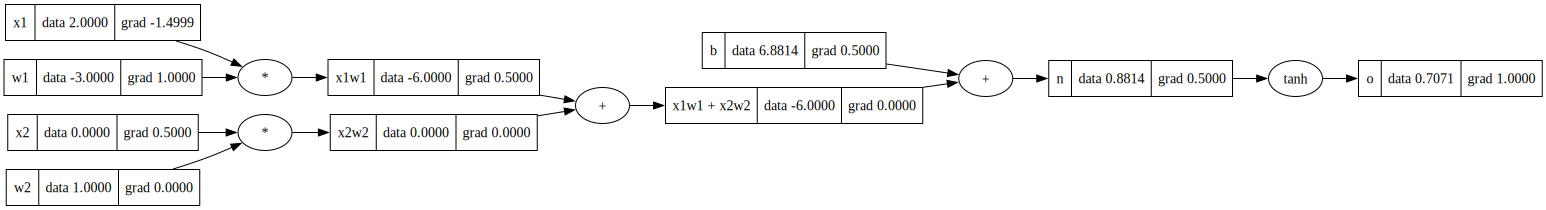

In [196]:
draw_dot(o)

In [201]:
be = Value(4.0, label='be')
bd = be + be; bd.label='bd'
bd.gradient(be)

In [202]:
print(be.grad)

2.0000000056086265


In [11]:
import torch

In [210]:
torch.device('cpu')

device(type='cpu')

In [12]:
x1 = torch.Tensor([2.0], device=torch.device('cpu')).double(); x1.requires_grad=True
w1 = torch.Tensor([-3.0], device=torch.device('cpu')).double(); w1.requires_grad=True
x2 = torch.Tensor([0.0], device=torch.device('cpu')).double(); x2.requires_grad=True
w2 = torch.Tensor([1.0], device=torch.device('cpu')).double(); w2.requires_grad=True
b = torch.Tensor([6.881374], device=torch.device('cpu')).double(); b.requires_grad=True

n  = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print (o.data.item())
o.backward()
print ('---------')
print (x1.grad.item())
print (w1.grad.item())
print (x2.grad.item())
print (w2.grad.item())

0.7071069288235958
---------
-1.4999993736289867
0.9999995824193244
0.4999997912096622
0.0


In [229]:
print(x1.dtype)
print(x1.data)

torch.float64
tensor([2.], dtype=torch.float64)


In [230]:
print(x1.item())
print(w2.grad.item())

2.0
0.0


In [39]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._children = _children
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __div__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data / other.data, (self, other), '/')
        def _backward():
            self.grad += (1 / other.data) * out.grad
            other.grad += (-self.data / (other.data**2)) * out.grad
        out._backward = _backward
        return out
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), '-')
        def _backward():
            self.grad += out.grad
            other.grad += -out.grad
        out._backward = _backward
        return out
    def __radd__(self, other):
        return self + other
    def __rmul__(self, other):
        return self * other
    def __rdiv__(self, other):
        return self / other
    def __rsub__(self, other):
        return self - other
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += (other * (self.data ** (other -1))) * out.grad
        out._backward = _backward
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    def backward(self):
        topo = []
        visited = set()
        def build(v):
            if v not in visited:
                visited.add(v)
                for child in v._children:
                    build(child)
                topo.append(v)
        build(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    def __repr__(self):
        return f"Value(data={self.data}), label={self.label}, children={len(self._children)}, op={self._op})"

In [102]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.randn()) for _ in range(nin)]
        self.b = Value(0.0)
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [16]:
import numpy as np
x = np.arange(-10, 10, 0.5)
w = np.arange(-5, 5, 0.25)
print(len(x), len(w))

40 40


In [241]:
len([(wi, xi) for wi, xi in zip(w,x)])

40

In [105]:
import math
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)


Value(data=0.48231754509574704), label=, children=1, op=tanh)

In [106]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.0, 0.0, 1.0],
    [1.0, 1.0, 1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
print(ypred)

[Value(data=0.48231754509574704), label=, children=1, op=tanh), Value(data=0.19283442304307943), label=, children=1, op=tanh), Value(data=-0.189904232388215), label=, children=1, op=tanh), Value(data=0.7339944632980625), label=, children=1, op=tanh)]


In [107]:
loss = sum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])
print(loss)

Value(data=2.417863183170823), label=, children=2, op=+)


In [108]:
loss.backward()

In [46]:
n.layers[0].neurons[0].w[0].grad

-151.27200325616073

In [337]:
n.parameters()

[Value(data=1.0035333533717268), label=, children=0, op=),
 Value(data=-0.7513292663646949), label=, children=0, op=),
 Value(data=2.3198504953934966), label=, children=0, op=),
 Value(data=-0.0026715405724241853), label=, children=0, op=),
 Value(data=-1.309059847321069), label=, children=0, op=),
 Value(data=-0.1530750290195418), label=, children=0, op=),
 Value(data=-0.2987792920064098), label=, children=0, op=),
 Value(data=0.06354356501975106), label=, children=0, op=),
 Value(data=1.0602525768554678), label=, children=0, op=),
 Value(data=1.6723549193915963), label=, children=0, op=),
 Value(data=1.4395684182547157), label=, children=0, op=),
 Value(data=-0.04995884448738647), label=, children=0, op=),
 Value(data=-0.03603958812249198), label=, children=0, op=),
 Value(data=1.9738847741702372), label=, children=0, op=),
 Value(data=-0.4778690452645207), label=, children=0, op=),
 Value(data=0.08277879525164467), label=, children=0, op=),
 Value(data=-1.52199137515829), label=, ch

In [331]:
for p in n.parameters():
    p.data += -0.1 * p.grad  # SGD
    p.grad = 0.0
ypred = [n(x) for x in xs]
loss = sum([(x-y)**2 for x,y in zip(ypred, ys)])
print(loss)
loss.backward()

Value(data=0.0006793574421084449), label=, children=2, op=+)


In [335]:
n([-2.0, 0.0, -1.0])

Value(data=0.9695028503531732), label=, children=1, op=tanh)